In [64]:
from os.path import dirname
import os
import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import swifter
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [65]:
pd.set_option('display.max_columns', 50)

In [66]:
%load_ext autoreload
%autoreload 2
import brandear_est as be

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
IMD_DIR = os.path.join(os.getcwd(), "../../data/intermediate/")
INPUT_DIR = os.path.join(os.getcwd(), "../../data/input")

IMD_INPUT_DIR = os.path.join(IMD_DIR, "pickled_inputs")
IMD_OUTPUT_DIR = os.path.join(IMD_DIR, "valid_aucs")
IMD_ARCHIVE_DIR = os.path.join(IMD_DIR, "arc_valid_aucs")

dset_to_period = {
    "pre_train": {"oldest": datetime.datetime(2019, 8, 26, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 3, 0, 0, 0)},    
    "train": {"oldest": datetime.datetime(2019, 9, 3, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 10, 0, 0, 0)},
    "valid_for_train": {"oldest": datetime.datetime(2019, 9, 10, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 17, 0, 0, 0),},    
    "valid_for_sub": {"oldest": datetime.datetime(2019, 9, 17, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 24, 0, 0, 0),},
    "submission": {"oldest": datetime.datetime(2019, 9, 24, 0, 0, 0),
              "newest": datetime.datetime(2019, 10, 1, 0, 0, 0),},    
}

In [68]:
# 元データ読み込み
auction = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "auction.pkl"))
watch = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "watch.pkl"))
bid = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "bid.pkl"))
bid_success = pd.read_pickle(os.path.join(IMD_INPUT_DIR , "bid_success.pkl"))
sample_sub = pd.read_csv(os.path.join(os.getcwd(), "../../data/input" , "sample_submission.csv"))
sub_users = sample_sub[["KaiinID"]].drop_duplicates()

# ブランド作成日
brand = be.read_csv(os.path.join(INPUT_DIR , "brand.csv"))
# itemcolorid付与(色の大分類)
color = be.read_csv(os.path.join(INPUT_DIR , "color.csv"))
# カテゴリーid,itemdailID付与のためのItemShouID付与
genre = be.read_csv(os.path.join(INPUT_DIR , "genre.csv"))
# itemshowID,itemdailID付与
itemshou = be.read_csv(os.path.join(INPUT_DIR , "itemshou.csv"))
# itemlineID付与
line = be.read_csv(os.path.join(INPUT_DIR , "line.csv"))

Mem. usage decreased to  0.32 Mb (15.0% reduction)
Mem. usage decreased to  0.01 Mb (32.2% reduction)
Mem. usage decreased to  0.00 Mb (45.4% reduction)
Mem. usage decreased to  0.00 Mb (33.4% reduction)
Mem. usage decreased to  0.01 Mb (41.3% reduction)


In [69]:
# オークション情報拡充
def rename(df, prefix):
    target_columns = ["ModifyDate", "CreateDate"]
    for target_column in target_columns:
        if target_column in df.columns:
            df.rename(columns={target_column: prefix + target_column}, inplace=True)
    return df

itemshou = rename(itemshou, prefix="ItemShow")
genre = rename(genre, prefix="Genre")
brand = rename(brand, prefix="Brand")
color = rename(color, prefix="Color")
line = rename(line, prefix="Line")

genre_mst = (
    genre[["GenreID", "ItemShouID", "CategoryID"]]
    .merge(itemshou[["ItemShouID", "ItemDaiID"]], on="ItemShouID", how="inner")
)

auction_mst = (
    auction
    .merge(genre_mst, on="GenreID", how="left")
    .merge(brand[["BrandID", "BrandCreateDate"]], on="BrandID", how="left")    
    .merge(color[["ColorID", "ItemColorID"]], on="ColorID", how="left")    
    .merge(line[["LineID", "ItemLineID", "LineCreateDate"]], on="LineID", how="left")        
    .fillna(0)
)
auction_mst = be.to_datetime(auction_mst[sorted(list(auction_mst.columns))])

In [70]:
def extract_target_actions(watch, bid, period):
    watch_actioned = (
        watch.loc[(watch["TourokuDate"] >= period["oldest"]) & (watch["TourokuDate"] < period["newest"]),
                  ["KaiinID", "AuctionID"]]
    )
    bid_actioned = (
        bid.loc[(bid["ShudouNyuusatsuDate"] >= period["oldest"]) & (bid["ShudouNyuusatsuDate"] < period["newest"]),
                ["KaiinID", "AuctionID"]]
    )

    watch_actioned["watch_actioned"] = 1
    bid_actioned["bid_actioned"] = 1

    target_actions = (
        watch_actioned
        .merge(bid_actioned, on=["KaiinID", "AuctionID"], how="outer")
        .drop_duplicates()
        .fillna(0)
    )
    return target_actions

    
def arrange_dtime_condition(watch, bid, bid_success, auction, period):
    retval = ((
        watch[watch["TourokuDate"] <= period["oldest"]],
        bid[bid["ShudouNyuusatsuDate"] <= period["oldest"]],
        bid_success[bid_success["RakusatsuDate"] < period["oldest"]],
        auction[auction["CreateDate"] < period["newest"]]
    ))
    return retval
    

def arrange_inputs(watch, bid, bid_success, auction, period):
    
    target_actions = extract_target_actions(watch, bid, period)
    
    watch_t, bid_t,  bid_success_t, auction_t = (
        arrange_dtime_condition(watch, bid, bid_success, auction, period)
    )
    
    arranged_inputs = (
        watch_t.merge(auction_t, on="AuctionID", how="left"),
        bid_t.merge(auction, on="AuctionID", how="left"),
        bid_success_t,
        auction_t,
        target_actions
    )
    return arranged_inputs

def extract_recent_data(df, date_col, base_dtime, days):
    oldest_dtime = base_dtime - relativedelta(days=days)
    return df[df[date_col] > oldest_dtime]

In [71]:
def build_dataset_input(auction, bid_success, watch, bid, period, dset_type):
    
    watch_arranged, bid_arranged, bid_success_arranged, auction_arranged, target_actions = (
        arrange_inputs(watch=watch, bid=bid, bid_success=bid_success, auction=auction, period=period)
    )

    aucs_with_cnts = (
        auction_arranged.merge(
            pd.concat([
            auction_arranged[(auction_arranged["CreateDate"] > period["newest"] - relativedelta(months=1))][["AuctionID"]],
            watch_arranged[(watch_arranged["TourokuDate"] > period["newest"] - relativedelta(months=1))][["AuctionID"]]
            ]).drop_duplicates(), on="AuctionID", how="inner")
    )
    
    # 落札しているオークションを除外
    aucs_with_cnts = be.left_anti_join(aucs_with_cnts, bid_success_arranged, "AuctionID", "AuctionID")
    
    # 正解データ付与
    target_aucs = target_actions[["AuctionID", "watch_actioned", "bid_actioned"]].groupby("AuctionID", as_index=False).max()
    aucs_with_cnts = aucs_with_cnts.merge(target_aucs, on="AuctionID", how="left").fillna(0)    
    
    aucs_with_cnts["Brand_SankouKakaku"] = aucs_with_cnts["SankouKakaku"].map(
        aucs_with_cnts[["BrandID", "SankouKakaku"]].groupby("BrandID")["SankouKakaku"].mean()
    ).fillna(0)
    
    aucs_with_cnts["inv_rate_to_Brand_SankouKakaku"] = aucs_with_cnts["Brand_SankouKakaku"] / aucs_with_cnts["SankouKakaku"]
        
    # クロス集計
    # クロス集計用にオークションデータ結合
    newest_dtime, oldest_dtime = (period["newest"], period["oldest"])        
    cross_conf = {
        "watch": watch_arranged,
        "bid": bid_arranged,
        "1m_watch": extract_recent_data(watch_arranged, "TourokuDate", oldest_dtime, 30),
        "1m_bid": extract_recent_data(bid_arranged, "ShudouNyuusatsuDate", oldest_dtime, 30)
    }        
    
    col_sets = [["AuctionID"], ["ShouhinID"], ["BrandID"], ["LineID"], ["ItemShouID"]]
    
    for prefix, feature_df in cross_conf.items():
        aucs_with_cnts = be.add_cross_counts(aucs_with_cnts, feature_df, prefix=prefix, col_sets=col_sets)
    
        
    # 経過日数の特徴量
    aucs_with_time = aucs_with_cnts
    aucs_with_time["elapsed_days"] = aucs_with_time["CreateDate"].apply(lambda d: (newest_dtime - d).days)
    
    dtime_feat_confs = [["watch", "TourokuDate", watch_arranged],
                       ["bid", "ShudouNyuusatsuDate", bid_arranged]]
    for dtime_feat_conf in dtime_feat_confs:
        prefix = dtime_feat_conf[0]
        last_action = (
            dtime_feat_conf[2][["AuctionID", dtime_feat_conf[1]]]
            .groupby("AuctionID", as_index=False).min()
            .rename(columns={dtime_feat_conf[1]: f"{prefix}_elapsed_days"})
        )
        last_action[f"{prefix}_elapsed_days"] = last_action[f"{prefix}_elapsed_days"].swifter.apply(lambda d: (oldest_dtime - d).days)
        aucs_with_time = aucs_with_time.merge(last_action, on="AuctionID", how="left").fillna(0)    
        
    be.df2pkl(aucs_with_time, IMD_ARCHIVE_DIR, f"{dset_type}_feature.pkl")


In [23]:
%%time
for dset_type in ["pre_train", "train", "valid_for_train", "valid_for_sub", "submission"]:
    build_dataset_input(
        auction=auction_mst,
        bid_success=bid_success,
        watch=watch,
        bid=bid,
        period=dset_to_period[dset_type],
        dset_type=dset_type
    )

##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']



##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']



##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']



##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']



##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']
##################
start cross count
[['AuctionID'], ['ShouhinID'], ['BrandID'], ['LineID'], ['ItemShouID']]
['AuctionID']
['ShouhinID']
['BrandID']
['LineID']
['ItemShouID']



CPU times: user 1min 28s, sys: 28.3 s, total: 1min 56s
Wall time: 2min 38s


In [74]:
pre_train_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/pre_train_feature.pkl")
train_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/train_feature.pkl")
vt_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/valid_for_train_feature.pkl")
vs_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/valid_for_sub_feature.pkl")
sub_dataset_input = pd.read_pickle(IMD_ARCHIVE_DIR + "/submission_feature.pkl")

In [75]:
def agg_target_cols(df):
    df["actioned"] = np.array(df[["watch_actioned", "bid_actioned"]].astype(int)).max(axis=1)
    
agg_target_cols(pre_train_dataset_input)
agg_target_cols(train_dataset_input)
agg_target_cols(vt_dataset_input)
agg_target_cols(vs_dataset_input)
agg_target_cols(sub_dataset_input)

In [76]:
drop_cols = ([
    "AuctionID", "BrandCreateDate", "BrandID", "CategoryID", "ColorID", "ConditionID", "CreateDate", "GenreGroupID",
    "GenreID", "ItemColorID", "ItemDaiID", "ItemLineID", "ItemShouID", "LineCreateDate", "LineID", "ShouhinID",
    "ShouhinShubetsuID", "watch_actioned", "bid_actioned", "actioned"
])

ptr_dataset = be.DataSet(data=pre_train_dataset_input, drop_cols=drop_cols, target_col="actioned")
tr_dataset = be.DataSet(data=train_dataset_input, drop_cols=drop_cols, target_col="actioned")
vt_dataset = be.DataSet(data=vt_dataset_input, drop_cols=drop_cols, target_col="watch_actioned")
vs_dataset = be.DataSet(data=vs_dataset_input, drop_cols=drop_cols, target_col="watch_actioned")
sub_dataset = be.DataSet(data=sub_dataset_input, drop_cols=drop_cols, target_col="watch_actioned")

In [77]:
# # 学習の様子可視化
datasets = [ptr_dataset]
for dataset in datasets:
    
    # train test split
    train_dataset, test_dataset =be.DataSet.train_test_split(dataset)
#     sampled_train = be.DataSet.under_sampling(train_dataset)

    # target encoding
    for cat_col in ["BrandID", "ItemShouID"]:
        train_dataset.add_target_encode(cat_col=cat_col)
        be.target_encode_for_test(train_dataset=train_dataset, test_dataset=test_dataset, cat_col=cat_col)    
    
    lgb_bi = be.LgbBinaryClassifier()
    lgb_bi.train(train_dataset=train_dataset, valid_dataset=test_dataset, desc=True)    

[1]	valid_0's auc: 0.748099
[2]	valid_0's auc: 0.75042
[3]	valid_0's auc: 0.750249
[4]	valid_0's auc: 0.751111
[5]	valid_0's auc: 0.751098
[6]	valid_0's auc: 0.753804
[7]	valid_0's auc: 0.754541
[8]	valid_0's auc: 0.755138
[9]	valid_0's auc: 0.755894
[10]	valid_0's auc: 0.756163
[11]	valid_0's auc: 0.756293
[12]	valid_0's auc: 0.756395
[13]	valid_0's auc: 0.756386
[14]	valid_0's auc: 0.756065
[15]	valid_0's auc: 0.756124
[16]	valid_0's auc: 0.756037
[17]	valid_0's auc: 0.756379
[18]	valid_0's auc: 0.756783
[19]	valid_0's auc: 0.757117
[20]	valid_0's auc: 0.757344
[21]	valid_0's auc: 0.757534
[22]	valid_0's auc: 0.757478
[23]	valid_0's auc: 0.757476
[24]	valid_0's auc: 0.757696
[25]	valid_0's auc: 0.757701
[26]	valid_0's auc: 0.757729
[27]	valid_0's auc: 0.7579
[28]	valid_0's auc: 0.757863
[29]	valid_0's auc: 0.757866
[30]	valid_0's auc: 0.757943
[31]	valid_0's auc: 0.758061
[32]	valid_0's auc: 0.758189
[33]	valid_0's auc: 0.758201
[34]	valid_0's auc: 0.758322
[35]	valid_0's auc: 0.7584

In [78]:
# 予測値取得

dataset_pairs = [
    [ptr_dataset, tr_dataset],
    [tr_dataset, vt_dataset],
    [vt_dataset, vs_dataset],
    [vs_dataset, sub_dataset]
]

for train_dataset, sub_dataset in dataset_pairs:
    
#     sampled_train = be.DataSet.under_sampling(train_dataset)
    # target encoding
    for cat_col in ["BrandID", "ItemShouID"]:
        train_dataset.add_target_encode(cat_col=cat_col)
        be.target_encode_for_test(train_dataset=train_dataset, test_dataset=sub_dataset, cat_col=cat_col)    

    lgb_bi = be.LgbBinaryClassifier()        
    lgb_bi.train(train_dataset=train_dataset)
    
    sub_dataset.set_pred(lgb_bi.predict(sub_dataset))    

auc :  0.7279253804699506


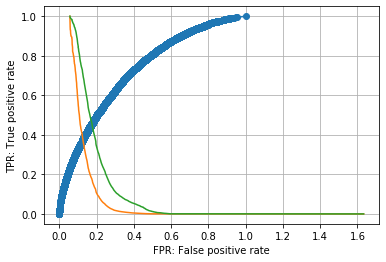

In [31]:
dataset = vs_dataset
print("auc : ", roc_auc_score(dataset.get_target(), dataset.data.pred))
be.plot_roc_curve(dataset.get_target(), dataset.data.pred)
be.plot_tpr_fpr(dataset.get_target(), dataset.data.pred)

In [13]:
# def show_th_info(th, dataset):
#     print("threshold : ", th)
#     print("data size : ", dataset.data.shape[0])
#     print("True count : ", dataset.data.query(f"({dataset.target_col} == 1)").shape[0])
#     print("True and False larger than threshold : ", dataset.data.query(f"pred >= {th}").shape[0])
#     print("True larger than threshold : ", dataset.data.query(f"(pred >= {th}) & ({dataset.target_col} == 1)").shape[0])

In [32]:
be.df2pkl(tr_dataset.data, IMD_OUTPUT_DIR, f"train.pkl")
be.df2pkl(vt_dataset.data, IMD_OUTPUT_DIR, f"valid_for_train.pkl")
be.df2pkl(tr_dataset.data, IMD_OUTPUT_DIR, f"valid_for_sub.pkl")
be.df2pkl(tr_dataset.data, IMD_OUTPUT_DIR, f"submission.pkl")

In [33]:
for dset_type, period in dset_to_period.items():
    print(dset_type)
    tmp = extract_target_actions(watch, bid, period)
    print("件数 : ", tmp.shape[0])
    print("watch : ", tmp.query("watch_actioned == 1")[["AuctionID"]].drop_duplicates().shape[0])
    print("bid : ", tmp.query("bid_actioned == 1")[["AuctionID"]].drop_duplicates().shape[0])
    print("watch and bid : ", tmp.query("(watch_actioned == 1) & (bid_actioned == 1)")[["AuctionID"]].drop_duplicates().shape[0])

pre_train
件数 :  88637
watch :  61784
bid :  10392
watch and bid :  4429
train
件数 :  82729
watch :  58425
bid :  8672
watch and bid :  3638
valid_for_train
件数 :  89910
watch :  62536
bid :  9042
watch and bid :  3743
valid_for_sub
件数 :  91044
watch :  64555
bid :  9153
watch and bid :  3852
submission
件数 :  0
watch :  0
bid :  0
watch and bid :  0


In [72]:
def stack_target_actions(target_actions):
    watch_target = target_actions.query("(watch_actioned == 1)")[["KaiinID", "AuctionID"]]
    bid_target = target_actions.query("(bid_actioned == 1)")[["KaiinID", "AuctionID"]]
    watch_target["score"] = 1
    bid_target["score"] = 2
    stacked_target_actions = pd.concat([watch_target, bid_target], sort=False)
    return stacked_target_actions

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    return np.sum((2 ** r - 1) / np.log2(np.arange(2, r.size + 2)))


def ndcg_at_k(r, k):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k) / dcg_max


def calc_ndcg(y_true, y_pred, k=20):
    y_pred_cp = y_pred.copy()

    actione_true = stack_target_actions(y_true)
    actione_true["rank"] = 100

    y_pred_cp['rank'] = y_pred_cp.groupby('KaiinID')['AuctionID'].cumcount()

    scored_pred = (
        y_pred_cp.merge(actione_true[["KaiinID", "AuctionID", "score"]], on=["KaiinID", "AuctionID"],
                        how="left").fillna(0))

    unchoiced_actiones = (
        be.left_anti_join(actione_true, y_pred_cp, ["KaiinID", "AuctionID"], ["KaiinID", "AuctionID"]))

    scored_actiones = (
        pd.concat([scored_pred, unchoiced_actiones], sort=False)
            .sort_values(["KaiinID", "rank"], ascending=["True", "True"]))

    dcgs = scored_actiones.groupby("KaiinID")["score"].apply(lambda s: ndcg_at_k(s.tolist(), k=20))
#     ndcg = dcgs.mean()

    return dcgs


In [73]:
def show_th_info(th, dataset, dset_type):
    print("threshold : ", th)
    print("data size : ", dataset.data.shape[0])
    print("True count : ", dataset.data.query(f"({dataset.target_col} == 1)").shape[0])
    print("True and False larger than threshold : ", dataset.data.query(f"pred >= {th}").shape[0])
    print("True larger than threshold : ", dataset.data.query(f"(pred >= {th}) & ({dataset.target_col} == 1)").shape[0])
    y_true = extract_target_actions(watch, bid, dset_to_period[dset_type])
    print("Target pair size", y_true.shape[0])
    cheat_pred = be.get_cheat_pred(
        dataset.data.query(f"pred >= {th}")[["AuctionID", "pred"]].merge(y_true[["AuctionID", "KaiinID"]], on="AuctionID", how="inner"),
        y_true
    )
    cheat_sub = be.adjust_sub_form(y_true[["KaiinID"]].drop_duplicates(), cheat_pred, drop=True)
    print(calc_ndcg(y_true, cheat_sub).mean())
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    axL.hist(dataset.data.query(f"({dataset.target_col} == 1)").pred, bins=100)
    axR.hist(dataset.data.query(f"({dataset.target_col} != 1)").pred, bins=100)

threshold :  0.1
data size :  364608
True count :  45441
True and False larger than threshold :  221217
True larger than threshold :  38934
Target pair size 91044
0.7674918412437286


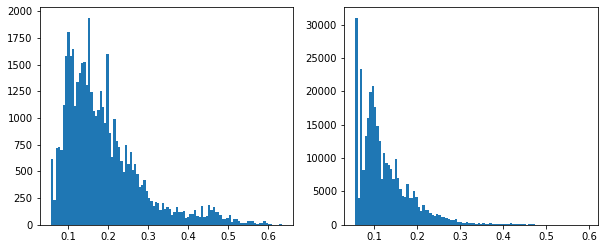

In [82]:
show_th_info(0.1, vs_dataset, "valid_for_sub")

In [56]:
20000 * 6000

120000000